<a href="https://www.kaggle.com/code/samithsachidanandan/rice-image-classification-cnn?scriptVersionId=279536442" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

### Importing Libraries

In [1]:
!pip install protobuf==3.20.3

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.1/162.1 kB 3.5 MB/s eta 0:00:00a 0:00:01
  Attempting uninstall: protobuf
    Found existing installation: protobuf 6.33.0
    Uninstalling protobuf-6.33.0:
      Successfully uninstalled protobuf-6.33.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 2.12.0 requires google-cloud-bigquery-storage<3.0.0,>=2.30.0, which is not installed.
opentelemetry-proto 1.37.0 requires protobuf<7.0,>=5.0, but you have protobuf 3.20.3 which is incompatible.
onnx 1.18.0 requires protobuf>=4.25.1, but you have protobuf 3.20.3 which is incompatible.
a2a-sdk 0.3.10 requires protobuf>=5.29.5, but you have protobuf 3.20.3 which is incompatible.
ray 2.51.1 requires click!=8.3.0,>=7.0, but you have click 8.3.0 which is incompatible.
bigframes 2.12.0 requires rich<14,>=12.4.4, but you have rich 14.2.0 which is incompatible.
tens

In [2]:
import tensorflow as tf 
from tensorflow.keras import models, layers 
import matplotlib.pyplot as plt 

2025-11-18 10:49:51.108552: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1763462991.476745      48 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1763462991.569803      48 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


### Config

In [3]:
IMAGE_SIZE = 128
BATCH_SIZE = 4
CHANNELS = 3
EPOCHS = 5
DATA_DIR ='/kaggle/input/rice-image-dataset/Rice_Image_Dataset'

### Loading the data 

In [4]:
dataset =tf.keras.preprocessing.image_dataset_from_directory(
    DATA_DIR,
    shuffle = True, 
    image_size = (IMAGE_SIZE, IMAGE_SIZE),
    batch_size = BATCH_SIZE
    )

Found 75000 files belonging to 5 classes.


2025-11-18 10:50:57.256416: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [5]:
class_names = dataset.class_names
class_names

['Arborio', 'Basmati', 'Ipsala', 'Jasmine', 'Karacadag']

In [6]:
len(dataset)

18750

### Visualizing the samples 

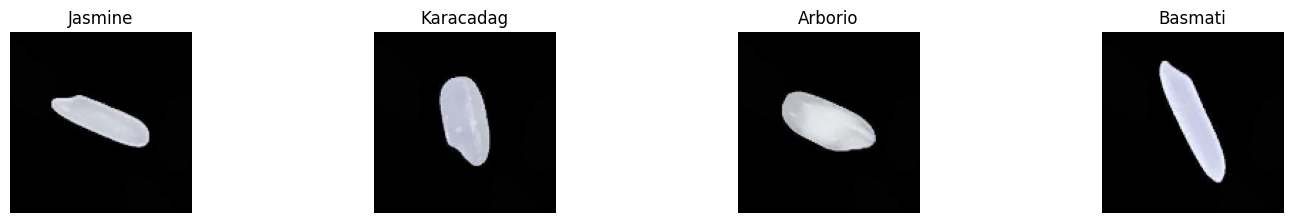

In [7]:
plt.figure(figsize=(18,8))
for image_batch, label_batch in dataset.take(1):

    num_images = min(12, len(image_batch)) 
    
    for i in range(num_images):
        ax = plt.subplot(3, 4, i+1)
        plt.imshow(image_batch[i].numpy().astype('uint8'))
        plt.title(class_names[label_batch[i]])   
        plt.axis('off')


### Train-Val-Test Split

In [8]:
def get_dataset_partitions_tf (ds,train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True,shuffle_size=10000 ):

    ds_size = len(ds)
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=42)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)



    return train_ds, val_ds, test_ds 

In [9]:
train_ds, val_ds,test_ds = get_dataset_partitions_tf(dataset)

In [10]:
train_ds = train_ds.shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=tf.data.AUTOTUNE)  
test_ds = test_ds.prefetch(buffer_size=tf.data.AUTOTUNE)

### Model 

In [11]:
input_shape = (IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = len(class_names)

model = models.Sequential([
    layers.Input(shape=input_shape), 
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),

])

In [12]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 57600)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │     3,686,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,706,181 (14.14 MB)

 Trainable params: 3,706,181 (14.14 MB)

 Non-trainable params: 0 (0.00 B)

In [13]:
model.compile(
        optimizer = 'adam',
        loss = tf.keras.losses.SparseCategoricalCrossentropy(),
        metrics =['accuracy']
)

### Training 

In [14]:
history= model.fit(
    train_ds, 
    epochs = EPOCHS,
    batch_size = BATCH_SIZE,
    verbose=1, 
    validation_data=val_ds
)

Epoch 1/5
15000/15000 ━━━━━━━━━━━━━━━━━━━━ 1057s 67ms/step - accuracy: 0.9244 - loss: 0.7560 - val_accuracy: 0.9832 - val_loss: 0.0526
Epoch 2/5
15000/15000 ━━━━━━━━━━━━━━━━━━━━ 1138s 74ms/step - accuracy: 0.9775 - loss: 0.0743 - val_accuracy: 0.9881 - val_loss: 0.0370
Epoch 3/5
15000/15000 ━━━━━━━━━━━━━━━━━━━━ 1048s 68ms/step - accuracy: 0.9832 - loss: 0.0537 - val_accuracy: 0.9913 - val_loss: 0.0298
Epoch 4/5
15000/15000 ━━━━━━━━━━━━━━━━━━━━ 1038s 68ms/step - accuracy: 0.9867 - loss: 0.0528 - val_accuracy: 0.9863 - val_loss: 0.0480
Epoch 5/5
15000/15000 ━━━━━━━━━━━━━━━━━━━━ 1055s 69ms/step - accuracy: 0.9880 - loss: 0.0469 - val_accuracy: 0.9901 - val_loss: 0.0426


In [15]:
scores = model.evaluate(test_ds)

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 89s 15ms/step - accuracy: 0.9888 - loss: 0.0388


In [16]:
print(f"Test Accuracy: {scores[1]*100:.2f}%")

Test Accuracy: 98.97%


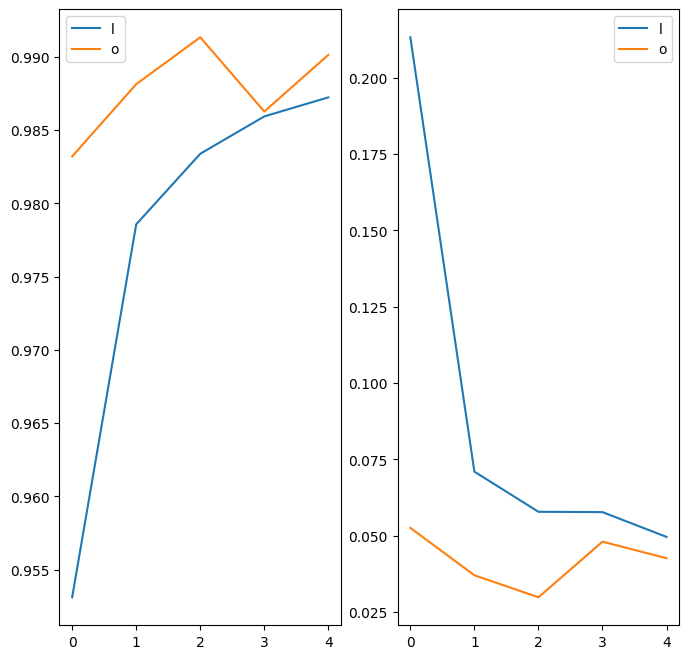

In [17]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.legend('lower right')


plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend('lower right')
plt.show()